In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from post_processing import *
from utils_mini import *
from fast_macro_f1_func import *

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_pickle('../features/train_v2.pkl')
df_test = pd.read_pickle('../features/test_v2.pkl')

sub = pd.read_csv("../input/sample_submission.csv")
sub['time'] = [format(sub.time.values[x], '.4f') for x in range(2000000)]
TARGET = "open_channels"

print(df_train.shape, df_test.shape, sub.shape)
df_train.head()

(4499872, 6) (2000000, 6) (2000000, 2)


,time,signal,open_channels,local_time,batch,mini_batch
0,0.0001,-2.7600,0,0.0001,1.0,1.0
1,0.0002,-2.8557,0,0.0002,1.0,1.0
2,0.0003,-2.4074,0,0.0003,1.0,1.0
3,0.0004,-3.1404,0,0.0004,1.0,1.0
4,0.0005,-3.1525,0,0.0005,1.0,1.0


In [4]:
def fe(df):
    
    for shift_val in range(1, 6):
    
        df[f'shift+{shift_val}'] = df.groupby(['batch']).shift(shift_val)['signal']
        df[f'shift_{shift_val}'] = df.groupby(['batch']).shift(-shift_val)['signal']
        df[f'diff+{shift_val}'] = df[f'shift+{shift_val}'] - df['signal']
        df[f'diff_{shift_val}'] = df[f'shift_{shift_val}'] - df['signal']
        
    return df

print("feature engineering on training data ...")
df_train = fe(df_train)
print("feature engineering on testing data ...")
df_test = fe(df_test) # should group mini-batch ***
print("feature engineering is done ...")

feature engineering on training data ...
feature engineering on testing data ...
feature engineering is done ...


In [5]:
color_list = [
    "b", "g", "r", "c", "m", "k", "y", '#0000FF', '#8A2BE2', '#A52A2A',
    '#DEB887', '#5F9EA0'
]

# drop useless features
drop_features = [
    "time",
    "open_channels",
    "local_time",
    "batch",
    "mini_batch",
    "oof",
]
all_features = [col for col in df_train.columns if col not in drop_features]

print("train/test shape is:", df_train.shape, df_test.shape)
print("features used # is", len(all_features))
df_train[all_features].head()

train/test shape is: (4499872, 26) (2000000, 26)
features used # is 21


,signal,shift+1,shift_1,diff+1,diff_1,shift+2,shift_2,diff+2,diff_2,shift+3,...,diff+3,diff_3,shift+4,shift_4,diff+4,diff_4,shift+5,shift_5,diff+5,diff_5
0,-2.7600,NaN,-2.8557,NaN,-0.0957,NaN,-2.4074,NaN,0.3526,NaN,...,NaN,-0.3804,NaN,-3.1525,NaN,-0.3925,NaN,-2.6418,NaN,0.1182
1,-2.8557,-2.7600,-2.4074,0.0957,0.4483,NaN,-3.1404,NaN,-0.2847,NaN,...,NaN,-0.2968,NaN,-2.6418,NaN,0.2139,NaN,-2.6993,NaN,0.1564
2,-2.4074,-2.8557,-3.1404,-0.4483,-0.7330,-2.7600,-3.1525,-0.3526,-0.7451,NaN,...,NaN,-0.2344,NaN,-2.6993,NaN,-0.2919,NaN,-2.5935,NaN,-0.1861
3,-3.1404,-2.4074,-3.1525,0.7330,-0.0121,-2.8557,-2.6418,0.2847,0.4986,-2.7600,...,0.3804,0.4411,NaN,-2.5935,NaN,0.5469,NaN,-2.6682,NaN,0.4722
4,-3.1525,-3.1404,-2.6418,0.0121,0.5107,-2.4074,-2.6993,0.7451,0.4532,-2.8557,...,0.2968,0.5590,-2.76,-2.6682,0.3925,0.4843,NaN,-2.7586,NaN,0.3939


In [6]:
param = {
    "objective": "regression",
    'metric': 'rmse',
    'num_leaves': 128,
    'learning_rate': 0.1,
    'n_estimators': 5000,
    'subsample': 0.25,
    "feature_fraction": 0.95,
    "lambda_l1": 0.5,
    "lambda_l2": 1.5,
    "max_depth": 8,
#     "min_child_weight": 0.1,
#     "min_split_gain": 0.001,
    'seed': 42,
    'n_jobs': -1
}

In [7]:
cv= 3
kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

# y_pred = np.zeros(df_test.shape[0])
df_test[TARGET] = 0
fi_df = pd.DataFrame(index=all_features)

### model 1 - batch 1&2

In [8]:
# model 1: batch 1&2
BATCH_GROUP_1 = [1,2]
df_train_1 = df_train[df_train.batch.isin(BATCH_GROUP_1)]
oof_pred = np.zeros(df_train_1.shape[0])

df_test_1_1 = df_test[(df_test.batch == 1) & (df_test.mini_batch == 1)]

In [9]:
param_1 = {
    "objective": "regression",
    'metric': 'rmse',
    'num_leaves': 128,
    'learning_rate': 0.03,
    'n_estimators': 5000,
    'subsample': 0.15,
    "feature_fraction": 0.95,
    "lambda_l1": 0.5,
    "lambda_l2": 1,
    "max_depth": 8,
    "min_child_weight": 42,
    "min_split_gain": 0.01,
    'seed': 42,
    'n_jobs': -1
}

param_1 = param

In [30]:
for fold, (train_index, valid_index) in enumerate(kf.split(df_train_1, y = df_train_1[TARGET])):

    print("Traning on folder", fold, "...")
    X_train, X_valid = df_train_1.iloc[train_index][all_features], df_train_1.iloc[valid_index][all_features]
    y_train, y_valid = df_train_1.iloc[train_index][TARGET], df_train_1.iloc[valid_index][TARGET]

    model_lgb = lgb.LGBMRegressor(**param_1)

    model_lgb.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=200)
    fi_df[f'importance_folder_{fold}'] = model_lgb.feature_importances_
    y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)
    oof_pred[valid_index] = y_pred_valid

    df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 1),TARGET] += model_lgb.predict(df_test_1_1[all_features], num_iteration=model_lgb.best_iteration_) / cv
    print("--- Vilid F1 score is", np.round(macro_f1_score_nb(df_train_1.iloc[valid_index][TARGET].astype(np.int32).values, y_pred_valid.round().astype(np.int32), 2), 4))
    print("")


Traning on folder 0 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's rmse: 0.0136507	valid_1's rmse: 0.0192151
--- Vilid F1 score is 0.9964

Traning on folder 1 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's rmse: 0.0140875	valid_1's rmse: 0.0188727
--- Vilid F1 score is 0.9966

Traning on folder 2 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's rmse: 0.0137347	valid_1's rmse: 0.0183584
--- Vilid F1 score is 0.9969



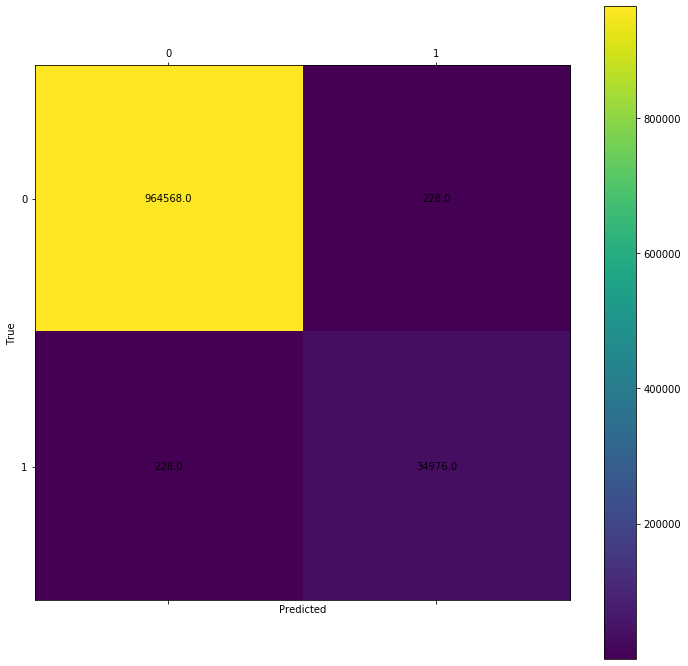

-------------------------------------
Overall F1 score is 0.99664


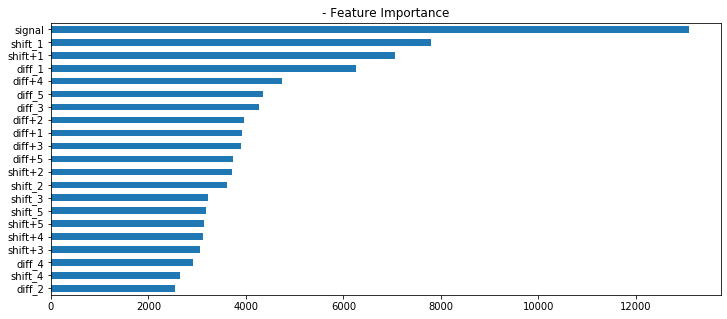

In [48]:
df_train.loc[df_train.batch.isin(BATCH_GROUP_1), "oof"] = oof_pred

df_train.loc[df_train.batch.isin(BATCH_GROUP_1),
             "oof"] = df_train.loc[df_train.batch.isin(BATCH_GROUP_1),
                                   "oof"] > 0.52

class_num = 2
cm = confusion_matrix(
    df_train.loc[df_train.batch.isin(BATCH_GROUP_1), TARGET],
    df_train.loc[df_train.batch.isin(BATCH_GROUP_1), "oof"].astype(int),
    range(class_num))
# cm = cm - np.eye(class_num) * cm
labels = range(class_num)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("-------------------------------------")

print(
    "Overall F1 score is",
    np.round(
        macro_f1_score_nb(
            df_train.loc[df_train.batch.isin(BATCH_GROUP_1),
                         TARGET].astype(np.int32).values,
            df_train.loc[df_train.batch.isin(BATCH_GROUP_1),
                         "oof"].astype(np.int32).values, 2), 5))

fi_df['importance'] = fi_df.sum(axis=1)
fi_df.sort_values('importance')['importance'].plot(
    kind='barh',
    figsize=(12, 5),
    title='- Feature Importance',
)
plt.show()

# 0.9967

In [ ]:
# # optimize the round prediction

# optRf = OptimizedRounderF1_model1()
# optRf.fit(df_train.loc[df_train.batch.isin(BATCH_GROUP_1), "oof"], df_train.loc[df_train.batch.isin(BATCH_GROUP_1), TARGET])
# coefficientsf = optRf.coefficients()
# print(coefficientsf)
# df_train.loc[df_train.batch.isin(BATCH_GROUP_1), "oof"] = optRf.predict(df_train.loc[df_train.batch.isin(BATCH_GROUP_1), "oof"], coefficientsf)
# df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 1),TARGET] = optRf.predict(df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 1),TARGET], coefficientsf)

### model 2 - batch 3&7

In [50]:
# model 2: batch 3&7
BATCH_GROUP_2 = [3,7]
df_train_2 = df_train[df_train.batch.isin(BATCH_GROUP_2)]
oof_pred = np.zeros(df_train_2.shape[0])

df_test_1_5 = df_test[(df_test.batch == 1) & (df_test.mini_batch == 5)]

In [51]:
param_2 = {
    "objective": "regression",
    'metric': 'rmse',
    'num_leaves': 128,
    'learning_rate': 0.03,
    'n_estimators': 5000,
    'subsample': 0.65,
    "feature_fraction": 0.95,
    "lambda_l1": 0.2,
    "lambda_l2": 0.8,
    "max_depth": 8,
    "min_child_weight": 42,
    "min_split_gain": 0.01,
    'seed': 42,
    'n_jobs': -1
}

param_2 = param

In [52]:
for fold, (train_index, valid_index) in enumerate(kf.split(df_train_2, y = df_train_2[TARGET])):

    print("Traning on folder", fold, "...")
    X_train, X_valid = df_train_2.iloc[train_index][all_features], df_train_2.iloc[valid_index][all_features]
    y_train, y_valid = df_train_2.iloc[train_index][TARGET], df_train_2.iloc[valid_index][TARGET]

    model_lgb = lgb.LGBMRegressor(**param_2)

    model_lgb.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=200)
    fi_df[f'importance_folder_{fold}'] = model_lgb.feature_importances_
    y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)
    oof_pred[valid_index] = y_pred_valid

    df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 5),TARGET] += model_lgb.predict(df_test_1_5[all_features], num_iteration=model_lgb.best_iteration_) / cv
    print("--- Vilid F1 score is", np.round(macro_f1_score_nb(df_train_2.iloc[valid_index][TARGET].astype(np.int32).values, y_pred_valid.round().astype(np.int32), 2), 4))
    print("")

Traning on folder 0 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's rmse: 0.0348366	valid_1's rmse: 0.0446215
--- Vilid F1 score is 0.9965

Traning on folder 1 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's rmse: 0.0354364	valid_1's rmse: 0.043525
--- Vilid F1 score is 0.9968

Traning on folder 2 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's rmse: 0.0351644	valid_1's rmse: 0.0449145
--- Vilid F1 score is 0.9965



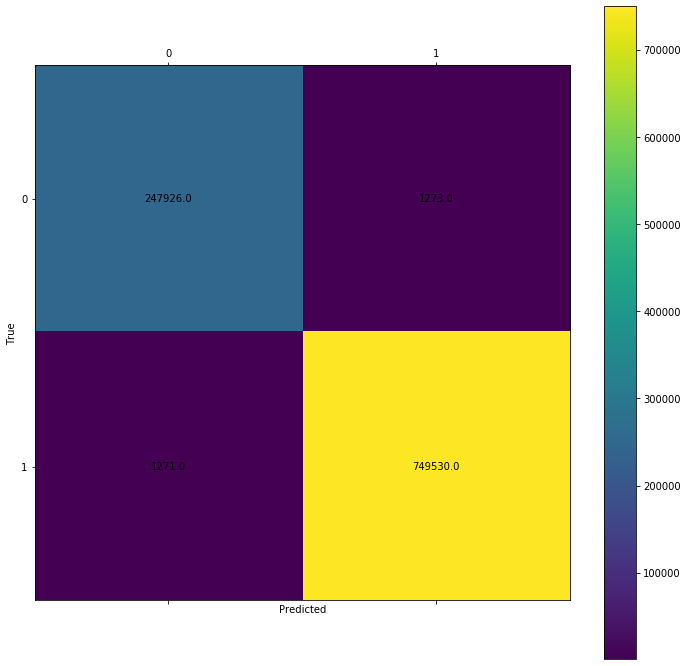

-------------------------------------
Overall F1 score is 0.9966


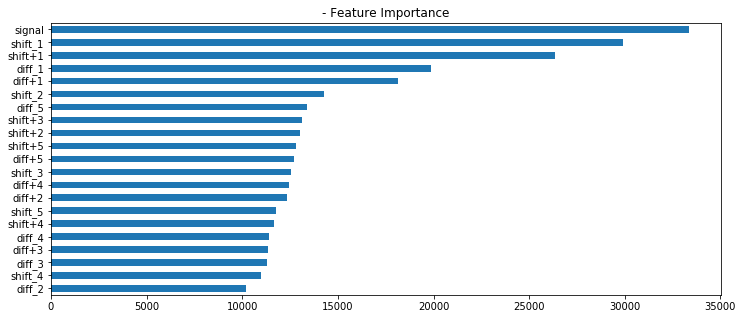

In [61]:
df_train.loc[df_train.batch.isin(BATCH_GROUP_2), "oof"] = oof_pred

df_train.loc[df_train.batch.isin(BATCH_GROUP_2),
             "oof"] = df_train.loc[df_train.batch.isin(BATCH_GROUP_2),
                                   "oof"] > 0.505

class_num = 2
cm = confusion_matrix(
    df_train.loc[df_train.batch.isin(BATCH_GROUP_2), TARGET],
    df_train.loc[df_train.batch.isin(BATCH_GROUP_2), "oof"].astype(int),
    range(class_num))
# cm = cm - np.eye(class_num) * cm
labels = range(class_num)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("-------------------------------------")

print("Overall F1 score is", np.round(macro_f1_score_nb(df_train.loc[df_train.batch.isin(BATCH_GROUP_2), TARGET].astype(np.int32).values, df_train.loc[df_train.batch.isin(BATCH_GROUP_2), "oof"].astype(np.int32).values, 2), 5))

fi_df['importance'] = fi_df.sum(axis=1)
fi_df.sort_values('importance')['importance'].plot(
    kind='barh',
    figsize=(12, 5),
    title='- Feature Importance',
)
plt.show()

# 0.9966

In [ ]:
# # optimize the round prediction

# optRf = OptimizedRounderF1_model1()
# optRf.fit(df_train.loc[df_train.batch.isin(BATCH_GROUP_2), "oof"], df_train.loc[df_train.batch.isin(BATCH_GROUP_2), TARGET])
# coefficientsf = optRf.coefficients()
# print(coefficientsf)
# df_train.loc[df_train.batch.isin(BATCH_GROUP_2), "oof"] = optRf.predict(df_train.loc[df_train.batch.isin(BATCH_GROUP_2), "oof"], coefficientsf)
# df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 5),TARGET] = optRf.predict(df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 5),TARGET], coefficientsf)

### model 3 - batch 4

In [62]:
# model 3: batch 4
BATCH_GROUP_3 = [4]
df_train_3 = df_train[df_train.batch.isin(BATCH_GROUP_3)]
oof_pred = np.zeros(df_train_3.shape[0])

# test batch 1-2
df_test_1_2 = df_test[(df_test.batch == 1) & (df_test.mini_batch == 2)]

# test batch 1-4
df_test_1_4 = df_test[(df_test.batch == 1) & (df_test.mini_batch == 4)]

# test batch 2-4
df_test_2_4 = df_test[(df_test.batch == 2) & (df_test.mini_batch == 4)]

# test batch 2-5
df_test_2_5 = df_test[(df_test.batch == 2) & (df_test.mini_batch == 5)]


In [63]:
param_3 = {
    "objective": "regression",
    'metric': 'rmse',
    'num_leaves': 128,
    'learning_rate': 0.03,
    'n_estimators': 5000,
    'subsample': 0.45,
    "feature_fraction": 0.85,
    "lambda_l1": 0.75,
    "lambda_l2": 1.5,
    "max_depth": 8,
    "min_child_weight": 42,
    "min_split_gain": 0.01,
    'seed': 42,
    'n_jobs': -1
}

param_3 = param

In [64]:
for fold, (train_index, valid_index) in enumerate(kf.split(df_train_3, y = df_train_3[TARGET])):

    print("Traning on folder", fold, "...")
    X_train, X_valid = df_train_3.iloc[train_index][all_features], df_train_3.iloc[valid_index][all_features]
    y_train, y_valid = df_train_3.iloc[train_index][TARGET], df_train_3.iloc[valid_index][TARGET]

    model_lgb = lgb.LGBMRegressor(**param_3)

    model_lgb.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=200)
    fi_df[f'importance_folder_{fold}'] = model_lgb.feature_importances_
    y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)
    oof_pred[valid_index] = y_pred_valid

    df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 2),TARGET] += model_lgb.predict(df_test_1_2[all_features], num_iteration=model_lgb.best_iteration_) / cv
    df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 4),TARGET] += model_lgb.predict(df_test_1_4[all_features], num_iteration=model_lgb.best_iteration_) / cv
    df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 4),TARGET] += model_lgb.predict(df_test_2_4[all_features], num_iteration=model_lgb.best_iteration_) / cv
    df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 5),TARGET] += model_lgb.predict(df_test_2_5[all_features], num_iteration=model_lgb.best_iteration_) / cv
    
    print("--- Vilid F1 score is", np.round(macro_f1_score_nb(df_train_3.iloc[valid_index][TARGET].astype(np.int32).values, y_pred_valid.round().astype(np.int32), 4), 4))
    print("")

Traning on folder 0 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's rmse: 0.0822438	valid_1's rmse: 0.0948272
--- Vilid F1 score is 0.9849

Traning on folder 1 ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's rmse: 0.0816532	valid_1's rmse: 0.0962334
--- Vilid F1 score is 0.9852

Traning on folder 2 ...
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.0757549	valid_1's rmse: 0.0951629
Early stopping, best iteration is:
[160]	training's rmse: 0.0776442	valid_1's rmse: 0.0951347
--- Vilid F1 score is 0.9852



In [ ]:
# # optimize the round prediction

# optRf = OptimizedRounderF1_model3()
# optRf.fit(df_train.loc[df_train.batch.isin(BATCH_GROUP_3), "oof"], df_train.loc[df_train.batch.isin(BATCH_GROUP_3), TARGET])
# coefficientsf = optRf.coefficients()
# print(coefficientsf)
# df_train.loc[df_train.batch.isin(BATCH_GROUP_3), "oof"] = optRf.predict(df_train.loc[df_train.batch.isin(BATCH_GROUP_3), "oof"], coefficientsf)
# df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 2),TARGET] = optRf.predict(df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 2),TARGET], coefficientsf)
# df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 4),TARGET] = optRf.predict(df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 4),TARGET], coefficientsf)
# df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 4),TARGET] = optRf.predict(df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 4),TARGET], coefficientsf)
# df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 5),TARGET] = optRf.predict(df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 5),TARGET], coefficientsf)

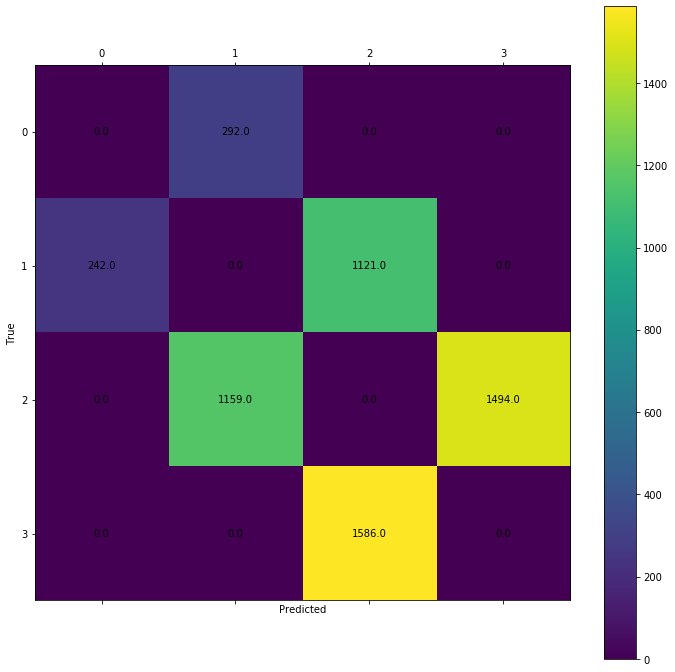

-------------------------------------
Overall F1 score is 0.9851


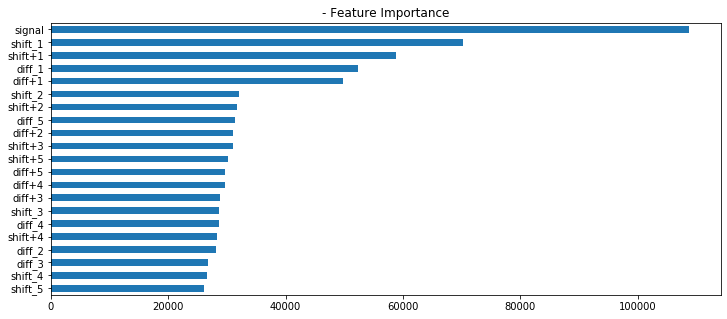

In [84]:
def round_optimize_model_3(val):
    thrh = [0.5, 1.5, 2.5]
    if val < thrh[0]:
        return 0
    elif val < thrh[1]:
        return 1
    elif val < thrh[2]:
        return 2
    else:
        return 3

df_train.loc[df_train.batch.isin(BATCH_GROUP_3), "oof"] = oof_pred

df_train.loc[df_train.batch.isin(BATCH_GROUP_3),
             "oof"] = df_train.loc[df_train.batch.isin(BATCH_GROUP_3),
                                   "oof"].apply(round_optimize_model_3)

class_num = 4
cm = confusion_matrix(
    df_train.loc[df_train.batch.isin(BATCH_GROUP_3), TARGET],
    df_train.loc[df_train.batch.isin(BATCH_GROUP_3), "oof"].astype(int),
    range(class_num))
cm = cm - np.eye(class_num) * cm
labels = range(class_num)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


print("-------------------------------------")

print("Overall F1 score is", np.round(macro_f1_score_nb(df_train.loc[df_train.batch.isin(BATCH_GROUP_3), TARGET].astype(np.int32).values, df_train.loc[df_train.batch.isin(BATCH_GROUP_3), "oof"].astype(np.int32).values, 4), 5))

fi_df['importance'] = fi_df.sum(axis=1)
fi_df.sort_values('importance')['importance'].plot(
    kind='barh',
    figsize=(12, 5),
    title='- Feature Importance',
)
plt.show()

# 0.9851

### model 4 - batch 6&9

In [17]:
# model 4: batch 6&9
BATCH_GROUP_4 = [6,9]
df_train_4 = df_train[df_train.batch.isin(BATCH_GROUP_4)]
oof_pred = np.zeros(df_train_4.shape[0])

# test batch 1-3
df_test_1_3 = df_test[(df_test.batch == 1) & (df_test.mini_batch == 3)]

# test batch 2-2
df_test_2_2 = df_test[(df_test.batch == 2) & (df_test.mini_batch == 2)]

In [18]:
param_4 = {
    "objective": "regression",
    'metric': 'rmse',
    'num_leaves': 128,
    'learning_rate': 0.03,
    'n_estimators': 5000,
    'subsample': 0.15,
    "feature_fraction": 0.8,
    "lambda_l1": 1,
    "lambda_l2": 1.5,
    "max_depth": 8,
    "min_child_weight": 42,
    "min_split_gain": 0.01,
    'seed': 42,
    'n_jobs': -1
}

param_4 = param

Traning on folder 0 ...
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.120879	valid_1's rmse: 0.13089
Early stopping, best iteration is:
[175]	training's rmse: 0.121619	valid_1's rmse: 0.130884
--- Vilid F1 score is 0.97

Traning on folder 1 ...
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.120405	valid_1's rmse: 0.131152
Early stopping, best iteration is:
[180]	training's rmse: 0.121093	valid_1's rmse: 0.131119
--- Vilid F1 score is 0.9687

Traning on folder 2 ...
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.120272	valid_1's rmse: 0.131745
Early stopping, best iteration is:
[164]	training's rmse: 0.121392	valid_1's rmse: 0.131717
--- Vilid F1 score is 0.9696

[0.5242527  1.51426638 2.48732495 3.5086215  4.5216621 ]
Overall F1 score is 0.9697


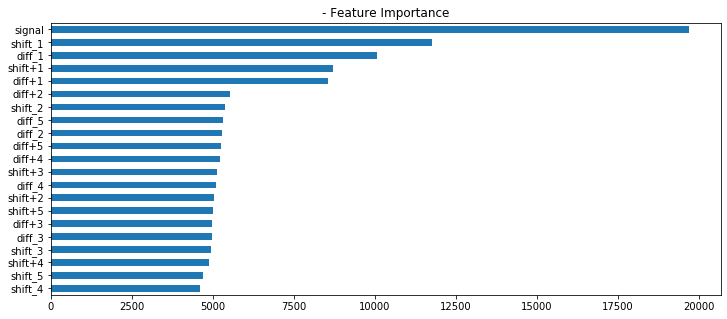

In [19]:
for fold, (train_index, valid_index) in enumerate(kf.split(df_train_4, y = df_train_4[TARGET])):

    print("Traning on folder", fold, "...")
    X_train, X_valid = df_train_4.iloc[train_index][all_features], df_train_4.iloc[valid_index][all_features]
    y_train, y_valid = df_train_4.iloc[train_index][TARGET], df_train_4.iloc[valid_index][TARGET]

    model_lgb = lgb.LGBMRegressor(**param_4)

    model_lgb.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=200)
    fi_df[f'importance_folder_{fold}'] = model_lgb.feature_importances_
    y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)
    oof_pred[valid_index] = y_pred_valid

    df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 3),TARGET] += model_lgb.predict(df_test_1_3[all_features], num_iteration=model_lgb.best_iteration_) / cv
    df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 2),TARGET] += model_lgb.predict(df_test_2_2[all_features], num_iteration=model_lgb.best_iteration_) / cv

    print("--- Vilid F1 score is", np.round(macro_f1_score_nb(df_train_4.iloc[valid_index][TARGET].astype(np.int32).values, y_pred_valid.round().astype(np.int32), 6), 4))
    print("")

# optimize the round prediction
df_train.loc[df_train.batch.isin(BATCH_GROUP_4), "oof"] = oof_pred
optRf = OptimizedRounderF1_model4()
optRf.fit(df_train.loc[df_train.batch.isin(BATCH_GROUP_4), "oof"], df_train.loc[df_train.batch.isin(BATCH_GROUP_4), TARGET])
coefficientsf = optRf.coefficients()
print(coefficientsf)
df_train.loc[df_train.batch.isin(BATCH_GROUP_4), "oof"] = optRf.predict(df_train.loc[df_train.batch.isin(BATCH_GROUP_4), "oof"], coefficientsf)
df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 3),TARGET] = optRf.predict(df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 3),TARGET], coefficientsf)
df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 2),TARGET] = optRf.predict(df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 2),TARGET], coefficientsf)

# print("-------------------------------------")

print("Overall F1 score is", np.round(macro_f1_score_nb(df_train.loc[df_train.batch.isin(BATCH_GROUP_4), TARGET].astype(np.int32).values, df_train.loc[df_train.batch.isin(BATCH_GROUP_4), "oof"].astype(np.int32).values, 6), 5))

fi_df['importance'] = fi_df.sum(axis=1)
fi_df.sort_values('importance')['importance'].plot(
    kind='barh',
    figsize=(12, 5),
    title='- Feature Importance',
)
plt.show()

# 0.9698

### model 5 - batch 5&10

In [20]:
# model 5: batch 5&10
BATCH_GROUP_5 = [5,10]
df_train_5 = df_train[df_train.batch.isin(BATCH_GROUP_5)]
oof_pred = np.zeros(df_train_5.shape[0])

# test batch 2-1
df_test_2_1 = df_test[(df_test.batch == 2) & (df_test.mini_batch == 1)]

# test batch 2-3
df_test_2_3 = df_test[(df_test.batch == 2) & (df_test.mini_batch == 3)]


In [21]:
param_5 = {
    "objective": "regression",
    'metric': 'rmse',
    'num_leaves': 128,
    'learning_rate': 0.1,
    'n_estimators': 5000,
    'subsample': 0.55,
    "feature_fraction": 0.95,
    "lambda_l1": 1,
    "lambda_l2": 1,
    "max_depth": 8,
    "min_child_weight": 1,
    "min_split_gain": 0.001,
    'seed': 42,
    'n_jobs': -1
}

# param_5 = param

Traning on folder 0 ...
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.279076	valid_1's rmse: 0.28838
Early stopping, best iteration is:
[148]	training's rmse: 0.281035	valid_1's rmse: 0.288312
--- Vilid F1 score is 0.8747

Traning on folder 1 ...
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.278393	valid_1's rmse: 0.289307
Early stopping, best iteration is:
[165]	training's rmse: 0.279657	valid_1's rmse: 0.289255
--- Vilid F1 score is 0.8756

Traning on folder 2 ...
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.279517	valid_1's rmse: 0.287638
Early stopping, best iteration is:
[141]	training's rmse: 0.281568	valid_1's rmse: 0.287581
--- Vilid F1 score is 0.8751

[2.62309855 3.51531053 4.55181599 5.5135871  6.50936404 7.52033805
 8.47917561 9.4995003 ]
Overall F1 score is 0.876


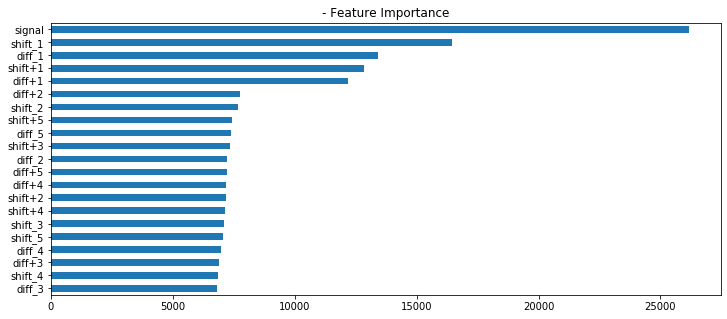

In [22]:
for fold, (train_index, valid_index) in enumerate(kf.split(df_train_5, y = df_train_5[TARGET])):

    print("Traning on folder", fold, "...")
    X_train, X_valid = df_train_5.iloc[train_index][all_features], df_train_5.iloc[valid_index][all_features]
    y_train, y_valid = df_train_5.iloc[train_index][TARGET], df_train_5.iloc[valid_index][TARGET]

    model_lgb = lgb.LGBMRegressor(**param_5)

    model_lgb.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=200)
    fi_df[f'importance_folder_{fold}'] = model_lgb.feature_importances_
    y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)
    oof_pred[valid_index] = y_pred_valid

    df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 1),TARGET] += model_lgb.predict(df_test_2_1[all_features], num_iteration=model_lgb.best_iteration_) / cv
    df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 3),TARGET] += model_lgb.predict(df_test_2_3[all_features], num_iteration=model_lgb.best_iteration_) / cv

    print("--- Vilid F1 score is", np.round(macro_f1_score_nb(df_train_5.iloc[valid_index][TARGET].astype(np.int32).values - 2, y_pred_valid.round().astype(np.int32) - 2, 9), 4))
    print("")

# optimize the round prediction
df_train.loc[df_train.batch.isin(BATCH_GROUP_5), "oof"] = oof_pred
optRf = OptimizedRounderF1_model5()
optRf.fit(df_train.loc[df_train.batch.isin(BATCH_GROUP_5), "oof"], df_train.loc[df_train.batch.isin(BATCH_GROUP_5), TARGET])
coefficientsf = optRf.coefficients()
print(coefficientsf)
df_train.loc[df_train.batch.isin(BATCH_GROUP_5), "oof"] = optRf.predict(df_train.loc[df_train.batch.isin(BATCH_GROUP_5), "oof"], coefficientsf)
df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 1),TARGET] = optRf.predict(df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 1),TARGET], coefficientsf)
df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 3),TARGET] = optRf.predict(df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 3),TARGET], coefficientsf)

# print("-------------------------------------")

print("Overall F1 score is", np.round(macro_f1_score_nb(df_train.loc[df_train.batch.isin(BATCH_GROUP_5), TARGET].astype(np.int32).values - 2, df_train.loc[df_train.batch.isin(BATCH_GROUP_5), "oof"].astype(np.int32).values - 2, 9), 5))

fi_df['importance'] = fi_df.sum(axis=1)
fi_df.sort_values('importance')['importance'].plot(
    kind='barh',
    figsize=(12, 5),
    title='- Feature Importance',
)
plt.show()

# 0.876

In [23]:
print("-------------------------------------") # 0.9393

print("Overall F1 score is", np.round(macro_f1_score_nb(df_train[TARGET].astype(np.int32).values, df_train["oof"].round().astype(np.int32).values, 11), 5))

-------------------------------------
Overall F1 score is 0.9393


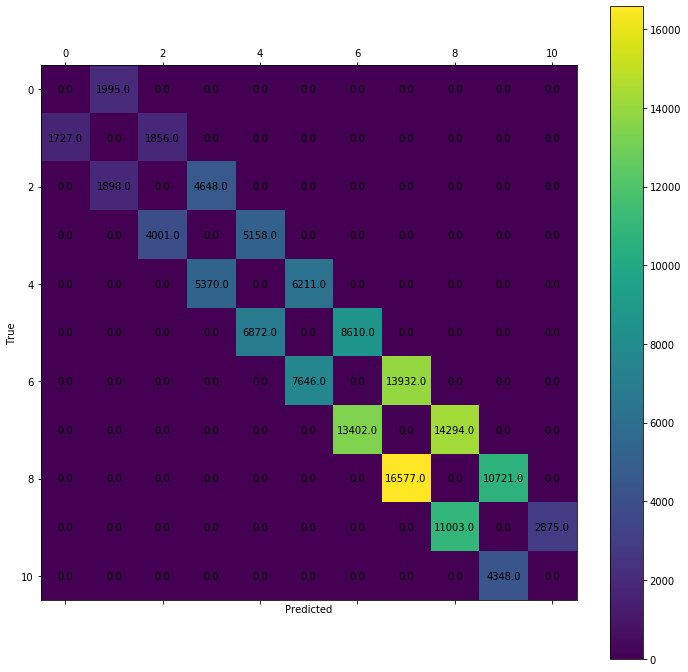

In [24]:
cm = confusion_matrix(df_train[TARGET], df_train["oof"], range(11))
cm = cm - np.eye(11) * cm
labels = range(11)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
# plt.plot(oof_pred, ".b",alpha=0.1)
# plt.plot(df_train.open_channels, ".r",alpha=0.1)

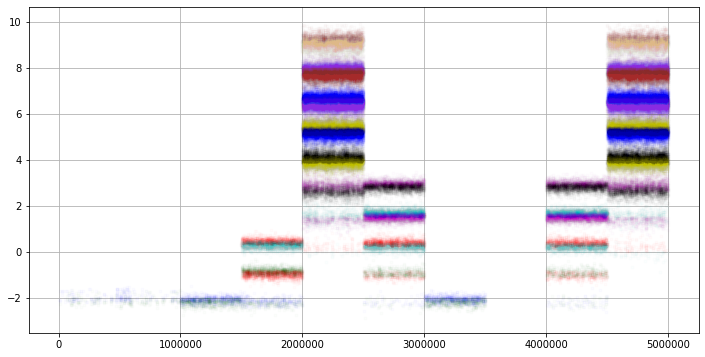

In [26]:
# oof error plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.open_channels == channel_i][df_train.oof != df_train.open_channels].signal, ".", color=color_list[channel_i], alpha=0.01)

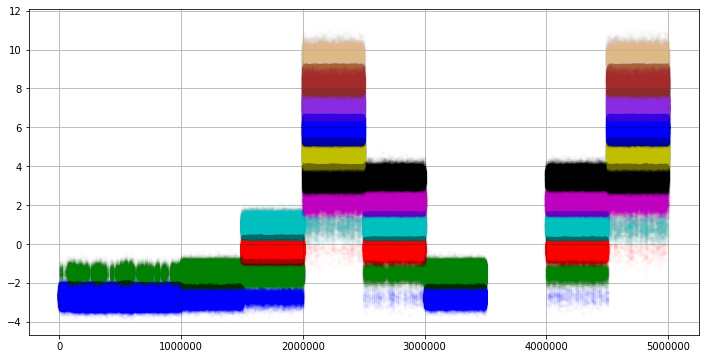

In [27]:
# oof plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.oof == channel_i].signal, ".", color=color_list[channel_i], alpha=0.01)

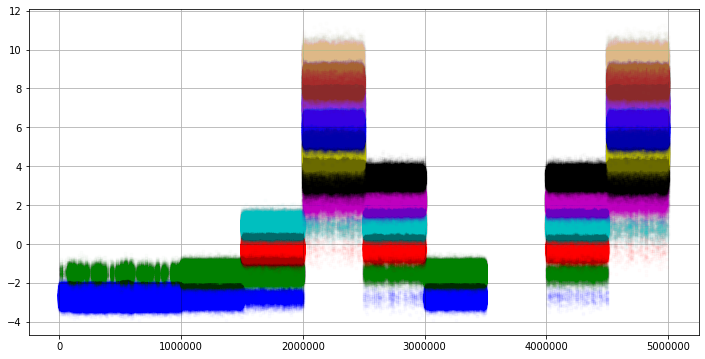

In [28]:
# train plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.open_channels == channel_i].signal, ".", color=color_list[channel_i], alpha=0.01)

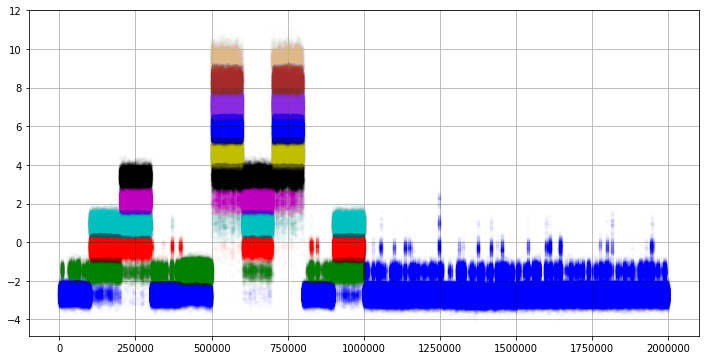

In [29]:
# test plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_test[df_test.open_channels == channel_i].signal, ".", color=color_list[channel_i], alpha=0.01)

In [30]:
# # look at markov 2-d oof
# for batch_i in df_train.batch.unique():
#     fig = plt.figure(figsize=(15,8))
#     for channel_i in df_train.open_channels.unique():
#         plt.plot(df_train[df_train.batch == batch_i][df_train.oof == channel_i].signal,
#                  df_train[df_train.batch == batch_i][df_train.oof == channel_i].shift_1,
#                  ".",
#                  c=color_list[channel_i],
#                  alpha=0.1)
#     plt.title("batch - " + str(batch_i))
#     plt.grid()
#     plt.show()

In [31]:
# # look at markov 2-d test
# for batch_i in df_test.batch.unique():
    
#     for mini_batch_i in df_test.mini_batch.unique():
#         fig = plt.figure(figsize=(15,8))
        
#         for channel_i in df_test.open_channels.unique():
#             plt.plot(df_test[df_test.batch == batch_i][df_test.mini_batch == mini_batch_i][df_test.open_channels == channel_i].signal,
#                      df_test[df_test.batch == batch_i][df_test.mini_batch == mini_batch_i][df_test.open_channels == channel_i].shift_1,
#                      ".",
#                      c=color_list[channel_i],
#                      alpha=0.05)
#         plt.title("batch - " + str(batch_i) + " - mini-batch " + str(mini_batch_i))
#         plt.grid()
#         plt.show()

In [32]:
sub["open_channels"] = df_test.open_channels.astype("int64")
sub.to_csv("../submissions/sub.csv", index=None)
sub.head()

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0


In [33]:
# df_train["open_channels_shift"] = df_train.open_channels.shift(1)
# df_train["diff"] = df_train["open_channels_shift"] - df_train["open_channels"] 